# Model Evaluation

## Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


Mounted at /content/drive


##Libraries

In [2]:
import os
import pandas as pd
import joblib

from sklearn.metrics import classification_report, f1_score

## Notebook Setup

In [3]:
ROOT_PATH = '/content/drive/MyDrive/generic-mix-topics-nlp'
DATA_PATH = os.path.join(ROOT_PATH, 'Data')
MODELS_PATH = os.path.join(ROOT_PATH, 'Models')

os.makedirs(MODELS_PATH, exist_ok=True)

## Data Loading

In [4]:
X_val = pd.read_parquet(os.path.join(DATA_PATH, 'X_val.parquet')).squeeze()
y_val = pd.read_parquet(os.path.join(DATA_PATH, 'y_val.parquet'))


X_test = pd.read_parquet(os.path.join(DATA_PATH, 'X_test.parquet')).squeeze()  # Converte in Series
y_test = pd.read_parquet(os.path.join(DATA_PATH, 'y_test.parquet'))


In [5]:
len(X_val)

36001

In [ ]:
y_val_grouped = pd.DataFrame()
y_test_grouped = pd.DataFrame()

y_val_grouped['Culture_and_Society'] = y_val[['Culture', 'Society', 'Human_behavior', 'Religion', 'Philosophy', 'Ethics', 'People']].max(axis=1)
y_val_grouped['Academic_Disciplines'] = y_val[['Academic_disciplines', 'Humanities', 'History', 'Education', 'Language', 'Law', 'Concepts', 'Time']].max(axis=1)
y_val_grouped['STEM'] = y_val[['Mathematics', 'Technology', 'Science', 'Engineering', 'Internet', 'Information', 'Knowledge']].max(axis=1)
y_val_grouped['Economics'] = y_val[['Economy', 'Business', 'Communication']].max(axis=1)
y_val_grouped['Health'] = y_val[['Health', 'Food_and_drink', 'Life']].max(axis=1)
y_val_grouped['Entertainment'] = y_val[['Entertainment', 'Sports', 'Mass_media']].max(axis=1)
y_val_grouped['Environment'] = y_val[['Geography', 'Nature', 'Energy', 'Universe']].max(axis=1)
y_val_grouped['Government'] = y_val[['Government', 'Politics', 'Military', 'Entities']].max(axis=1)

# Raggruppamento delle etichette nel set di test
y_test_grouped['Culture_and_Society'] = y_test[['Culture', 'Society', 'Human_behavior', 'Religion', 'Philosophy', 'Ethics', 'People']].max(axis=1)
y_test_grouped['Academic_Disciplines'] = y_test[['Academic_disciplines', 'Humanities', 'History', 'Education', 'Language', 'Law', 'Concepts', 'Time']].max(axis=1)
y_test_grouped['STEM'] = y_test[['Mathematics', 'Technology', 'Science', 'Engineering', 'Internet', 'Information', 'Knowledge']].max(axis=1)
y_test_grouped['Economics'] = y_test[['Economy', 'Business', 'Communication']].max(axis=1)
y_test_grouped['Health'] = y_test[['Health', 'Food_and_drink', 'Life']].max(axis=1)
y_test_grouped['Entertainment'] = y_test[['Entertainment', 'Sports', 'Mass_media']].max(axis=1)
y_test_grouped['Environment'] = y_test[['Geography', 'Nature', 'Energy', 'Universe']].max(axis=1)
y_test_grouped['Government'] = y_test[['Government', 'Politics', 'Military', 'Entities']].max(axis=1)

## Model Loading

In [ ]:

logreg_model = joblib.load(os.path.join(MODELS_PATH, 'logistic_regression_pipeline_v1.pkl'))
nb_model = joblib.load(os.path.join(MODELS_PATH, 'naive_bayes_pipeline.pkl'))
svm_model = joblib.load(os.path.join(MODELS_PATH, 'linear_svc_pipeline_v1.pkl'))




# Caricamento dei modelli per le etichette raggruppate
logreg_grouped_model = joblib.load(os.path.join(MODELS_PATH, 'logreg_grouped_model.pkl'))
svm_grouped_model = joblib.load(os.path.join(MODELS_PATH, 'svm_grouped_model.pkl'))

print("Dati e modelli caricati con successo.")

Dati e modelli caricati con successo.


## Utils

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Funzione per estrarre le metriche dal classification report
def extract_metrics(report):
    metrics = {
        'weighted_avg_f1': report['weighted avg']['f1-score'],
        'micro_avg_f1': report['micro avg']['f1-score'],
        'macro_avg_f1': report['macro avg']['f1-score'],
        'samples_avg_f1': report['samples avg']['f1-score']
    }
    return metrics

In [ ]:
import numpy as np
def evaluate_logistic_regression_with_thresholds(model, X_val, y_val, thresholds=np.arange(0.1, 1.0, 0.1)):
    best_threshold = 0.5
    best_f1_score = 0
    best_metrics = None

    # Ottieni le probabilità predette
    y_proba = model.predict_proba(X_val)

    for threshold in thresholds:
        # Converto le probabilità in previsioni binarie usando il threshold corrente
        y_pred_threshold = (y_proba >= threshold).astype(int)

        # Genera il report di classificazione
        report_logreg = classification_report(y_val, y_pred_threshold, output_dict=True)

        # Estrai le metriche usando la funzione fornita
        metrics_logreg = extract_metrics(report_logreg)


        # Confronta l'F1 score macro e aggiorna il miglior threshold se necessario
        if metrics_logreg['macro_avg_f1'] > best_f1_score:
            best_f1_score = metrics_logreg['macro_avg_f1']
            best_threshold = threshold
            best_metrics = metrics_logreg

    # Aggiungi il miglior risultato ai risultati finali
    best_metrics['model'] = f'Logistic Regression (threshold={best_threshold:.1f})'
    return best_metrics

## Evaluation (All Labels)

In [6]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer
from sklearn.metrics import classification_report
import numpy as np
import os

# Imposta il dispositivo (GPU se disponibile)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carica il modello pre-addestrato dal percorso salvato
MODEL_SAVE_PATH = os.path.join(MODELS_PATH, 'distilbert_model')
model_llm = DistilBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(device)

# Usa il tokenizer pre-addestrato di DistilBERT ('distilbert-base-uncased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Supponiamo che X_val e y_val siano già definiti

# Tokenizza il validation set
X_val_tokens = tokenizer(list(X_val), truncation=True, padding=True, max_length=512, return_tensors='pt')

# Non è necessario binarizzare di nuovo le etichette del validation set se sono già binarizzate
y_val_tensor = torch.tensor(y_val.values).float()

# Crea un dataset personalizzato per il validation set
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Crea un dataset per il validation set
val_dataset = CustomDataset(X_val_tokens, y_val_tensor)

# Usa Trainer per fare le previsioni
trainer = Trainer(model=model_llm)

# Prevedere sul validation set
val_predictions = trainer.predict(val_dataset)

# Ottieni le previsioni come logits dal validation set
val_logits = val_predictions.predictions

# Converti i logits in probabilità con una funzione sigmoide
val_pred_probs = torch.sigmoid(torch.tensor(val_logits)).numpy()

# Valutazione su diversi threshold
best_f1_score = 0
best_threshold = 0.5
best_report = None

thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    # Converti le probabilità in etichette binarie usando il threshold corrente
    y_val_pred = (val_pred_probs >= threshold).astype(int)

    # Genera il report di classificazione
    report = classification_report(y_val, y_val_pred, target_names=y_val.columns, output_dict=True, zero_division=0)

    # Estrai l'F1 score macro e confrontalo
    f1_score_macro = report['macro avg']['f1-score']
    if f1_score_macro > best_f1_score:
        best_f1_score = f1_score_macro
        best_threshold = threshold
        best_report = report

# Stampa i risultati
print(f"Best Threshold: {best_threshold}")
print("Best Validation Results")
print(classification_report(y_val, (val_pred_probs >= best_threshold).astype(int), target_names=y_val.columns))

# Appendere i risultati migliori alla lista results
results = []

metrics_llm = {
    'model': f'LLM (DistilBERT, threshold={best_threshold:.1f})',
    'macro_avg_f1': best_report['macro avg']['f1-score'],
    'micro_avg_f1': best_report['micro avg']['f1-score'],
    'weighted_avg_f1': best_report['weighted avg']['f1-score'],
    'samples_avg_f1': best_report['samples avg']['f1-score'],
}

results.append(metrics_llm)

# Visualizzare i risultati
results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Best Threshold: 0.4
Best Validation Results
                      precision    recall  f1-score   support

       Entertainment       0.80      0.82      0.81      6389
             Culture       0.53      0.43      0.47      4103
          Mass_media       0.71      0.78      0.74      5756
Academic_disciplines       0.40      0.22      0.29      1376
            Business       0.56      0.57      0.57      2396
       Communication       0.31      0.39      0.35       137
            Concepts       0.49      0.48      0.48       377
             Economy       0.66      0.60      0.63      1527
           Education       0.66      0.62      0.64      2857
              Energy       0.62      0.67      0.64       437
         Engineering       0.53      0.42      0.47      1109
            Entities       0.25      0.03      0.05       919
              Ethics       0.19      0.37      0.25        51
      Food_and_drink       0.77      0.58      0.66       599
           Geography     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
results_df

,model,macro_avg_f1,micro_avg_f1,weighted_avg_f1,samples_avg_f1
0,"LLM (DistilBERT, threshold=0.4)",0.577853,0.68348,0.677247,0.673082


In [ ]:
results = []

print("Evaluating Logistic Regression")
metrics_logreg = evaluate_logistic_regression_with_thresholds(logreg_model, X_val, y_val)
results.append(metrics_logreg)

# Valutare Multinomial Naive Bayes
print("Evaluating Multinomial Naive Bayes")
y_pred_nb = nb_model.predict(X_val)
report_nb = classification_report(y_val, y_pred_nb, output_dict=True)
metrics_nb = extract_metrics(report_nb)
metrics_nb['model'] = 'Multinomial Naive Bayes'
results.append(metrics_nb)

# Valutare SVM
print("Evaluating SVM")
y_pred_svm = svm_model.predict(X_val)
report_svm = classification_report(y_val, y_pred_svm, output_dict=True)
metrics_svm = extract_metrics(report_svm)
metrics_svm['model'] = 'SVM'
results.append(metrics_svm)

# Visualizzare i risultati
results_df = pd.DataFrame(results)
print(results_df)

Evaluating Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Evaluating Multinomial Naive Bayes


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating SVM
   weighted_avg_f1  micro_avg_f1  macro_avg_f1  samples_avg_f1  \
0         0.681679      0.682390      0.597041        0.679022   
1         0.173175      0.219992      0.055455        0.176101   
2         0.662790      0.679695      0.569613        0.658961   

                                 model  
0  Logistic Regression (threshold=0.2)  
1              Multinomial Naive Bayes  
2                                  SVM  


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_df

,weighted_avg_f1,micro_avg_f1,macro_avg_f1,samples_avg_f1,model
0,0.681679,0.682390,0.597041,0.679022,Logistic Regression (threshold=0.2)
1,0.173175,0.219992,0.055455,0.176101,Multinomial Naive Bayes
2,0.662790,0.679695,0.569613,0.658961,SVM


In [ ]:
import numpy as np

# Recupera il TfidfVectorizer dalla pipeline
tfidf = logreg_model.named_steps['tfidf']
# Recupera il modello OneVsRestClassifier dalla pipeline
logreg_ovr = logreg_model.named_steps['clf']

# Ottieni i nomi delle feature (le parole nel vocabolario)
feature_names = tfidf.get_feature_names_out()

# Creare un dizionario per memorizzare le 3 parole più influenti e i loro coefficienti per ogni label
top_words_per_label = {}

# Itera su ogni etichetta
for idx, label in enumerate(y_val.columns):
    # Prendi il classificatore binario corrispondente alla classe 'idx'
    logreg = logreg_ovr.estimators_[idx]

    # Prendi i coefficienti per questa etichetta
    coef = logreg.coef_[0]

    # Filtra i coefficienti positivi e trova gli indici delle 3 caratteristiche (parole) con i pesi più alti
    positive_indices = np.where(coef > 0)[0]
    top3_indices = positive_indices[np.argsort(coef[positive_indices])[-3:]]

    # Ottieni le parole corrispondenti, i coefficienti e i pesi TF-IDF
    top3_words_and_coefs = [(feature_names[i], coef[i], tfidf.idf_[i]) for i in top3_indices]

    # Aggiungi al dizionario
    top_words_per_label[label] = top3_words_and_coefs

# Visualizza le 3 parole più influenti, i loro coefficienti e i pesi TF-IDF per ogni etichetta
for label, words_and_coefs in top_words_per_label.items():
    words_with_coefs = ', '.join([f"{word}: coef={coef:.4f}, tfidf={idf:.4f}" for word, coef, idf in words_and_coefs])
    print(f"Label: {label} - Top 3 positive words: {words_with_coefs}")


Label: Entertainment - Top 3 positive words: cast: coef=6.1753, tfidf=4.0950, track listing: coef=6.3868, tfidf=4.4928, wrestling: coef=6.9184, tfidf=6.1176
Label: Culture - Top 3 positive words: series: coef=3.9517, tfidf=3.2893, worn: coef=4.3116, tfidf=6.5910, track listing: coef=6.5458, tfidf=4.4928
Label: Mass_media - Top 3 positive words: newspaper: coef=6.6862, tfidf=4.6687, cast: coef=8.2844, tfidf=4.0950, film directed: coef=8.8392, tfidf=4.9619
Label: Academic_disciplines - Top 3 positive words: metro: coef=4.7052, tfidf=5.8978, orchid: coef=4.7074, tfidf=7.6063, hotel: coef=5.3654, tfidf=5.0210
Label: Business - Top 3 positive words: company: coef=6.4796, tfidf=3.2153, businessman: coef=6.6174, tfidf=5.4083, business: coef=7.1725, tfidf=3.7729
Label: Communication - Top 3 positive words: telecommunication: coef=4.8660, tfidf=6.2355, whale: coef=4.9596, tfidf=7.2476, communication: coef=5.1748, tfidf=4.7236
Label: Concepts - Top 3 positive words: ligament: coef=4.5545, tfidf=

In [ ]:
# Carica X_test e y_test
X_test = pd.read_parquet(os.path.join(DATA_PATH, 'X_test.parquet')).squeeze()  # Converte in Series
y_test = pd.read_parquet(os.path.join(DATA_PATH, 'y_test.parquet'))

# Prevedere sul test set con SVM
y_proba_logreg_test = logreg_model.predict_proba(X_test)

# Converti le probabilità in etichetteS binarie usando il threshold = 0.2
threshold = 0.2
y_pred_logreg_test = (y_proba_logreg_test >= threshold).astype(int)

# Valutazione del modello Logistic Regression sul test set
print("Logistic Regression Test Results (Threshold = 0.2)")
print(classification_report(y_test, y_pred_logreg_test, target_names=y_test.columns))

Logistic Regression Test Results (Threshold = 0.2)
                      precision    recall  f1-score   support

       Entertainment       0.71      0.91      0.80      6574
             Culture       0.46      0.65      0.54      4127
          Mass_media       0.64      0.89      0.75      5895
Academic_disciplines       0.45      0.43      0.44      1339
            Business       0.53      0.67      0.59      2416
       Communication       0.65      0.13      0.22       128
            Concepts       0.61      0.43      0.51       367
             Economy       0.64      0.65      0.65      1536
           Education       0.59      0.72      0.65      2737
              Energy       0.69      0.66      0.67       462
         Engineering       0.47      0.44      0.46      1049
            Entities       0.41      0.20      0.27       850
              Ethics       0.60      0.05      0.09        59
      Food_and_drink       0.76      0.56      0.64       572
           Geograp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-31-5f034931e4e9>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(supports), vmax=np.max(supports))), label='Support')


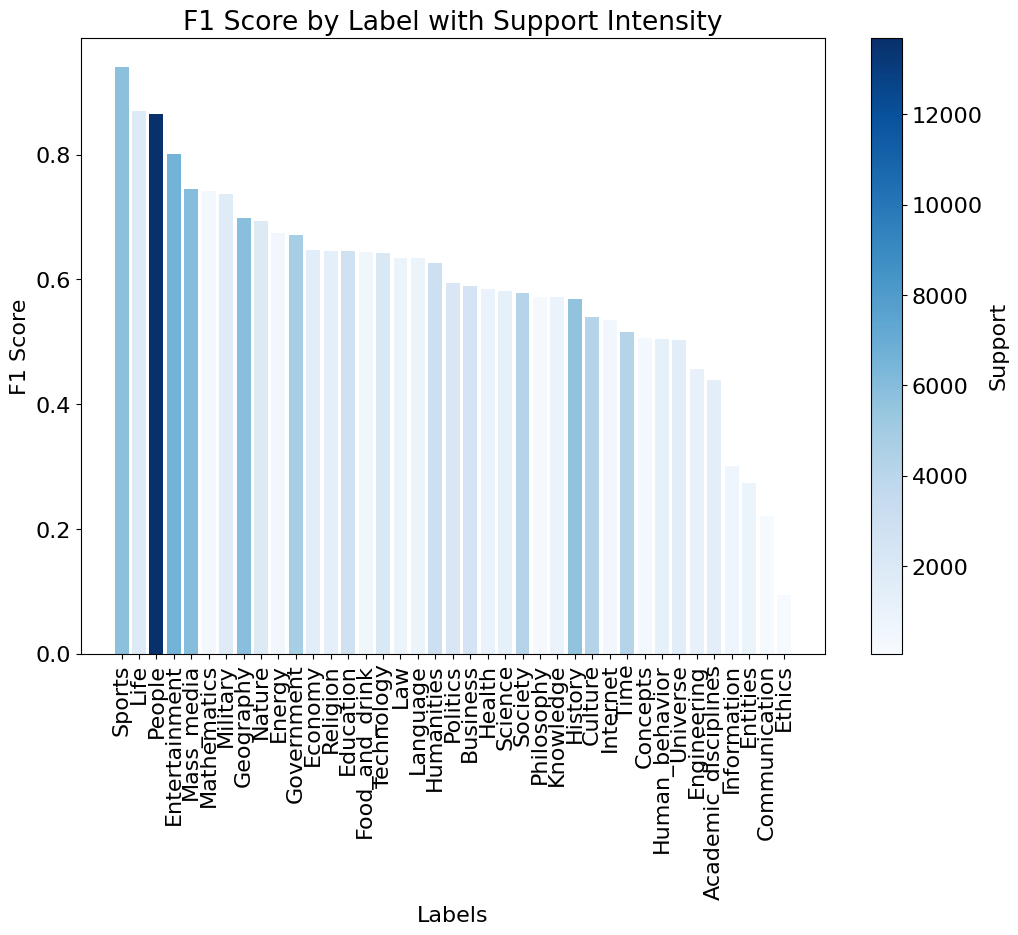

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Supponiamo che y_test e y_pred siano già definiti
report = classification_report(y_test, y_pred_logreg_test, target_names=y_test.columns, output_dict=True)

# Estrai l'F1 score per ogni etichetta
labels = y_test.columns
f1_scores = [report[label]['f1-score'] for label in labels]

# Estrai la numerosità (support) per ogni etichetta
supports = [report[label]['support'] for label in labels]

# Ordina le etichette, gli F1 score, e i support in base all'F1 score dal più alto al più basso
sorted_indices = np.argsort(f1_scores)[::-1]  # Ordina dal più alto al più basso
labels = np.array(labels)[sorted_indices]
f1_scores = np.array(f1_scores)[sorted_indices]
supports = np.array(supports)[sorted_indices]

# Normalizza i valori di support per mappare l'intensità del colore
norm_supports = supports / np.max(supports)

# Crea il barplot con l'intensità del colore basata sul support utilizzando una scala di blu
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, f1_scores, color=plt.cm.Blues(norm_supports))

# Aggiungi etichette e titolo in inglese
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Score by Label with Support Intensity')
plt.xticks(rotation=90)
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(supports), vmax=np.max(supports))), label='Support')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-24-0d6b771b2ad3>:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(mean_tfidf), vmax=np.max(mean_tfidf))), label='Mean TF-IDF Weight')


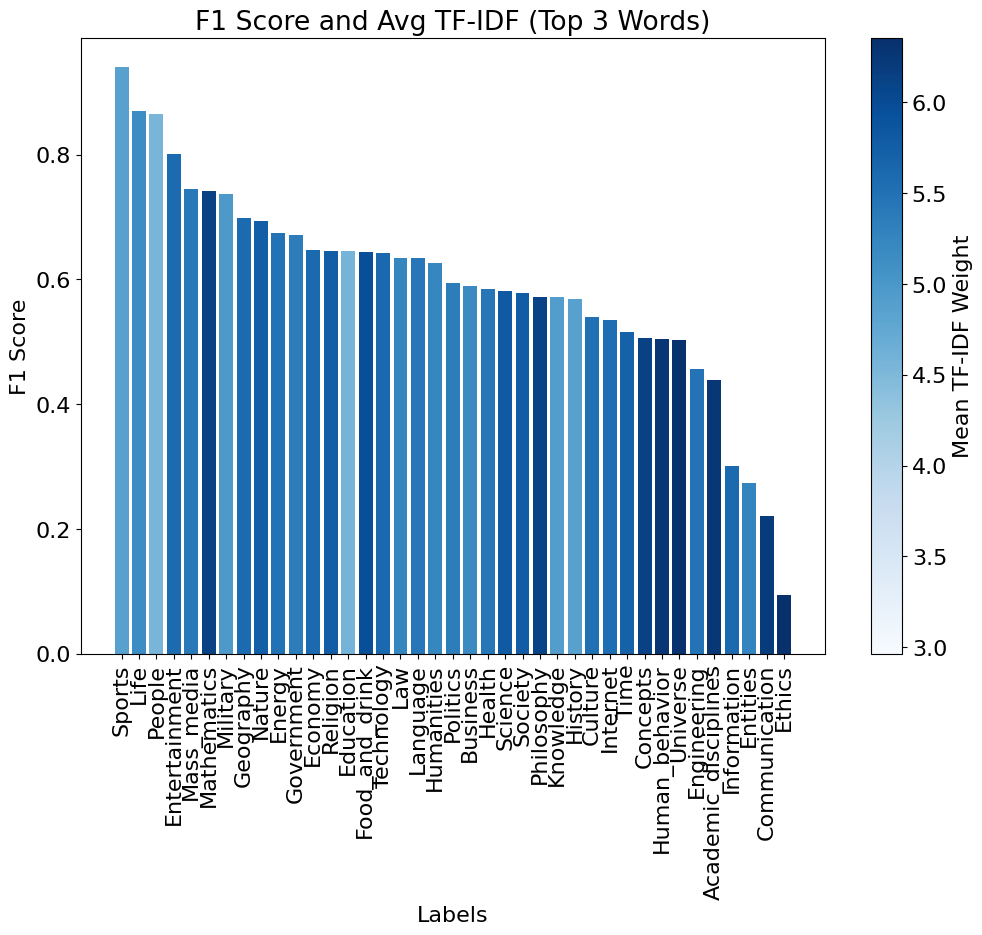

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Supponendo che y_test e y_pred_logreg_test siano già definiti
report = classification_report(y_test, y_pred_logreg_test, target_names=y_test.columns, output_dict=True)

# Estrai l'F1 score per ogni etichetta
labels = y_test.columns
f1_scores = [report[label]['f1-score'] for label in labels]

# Calcola la media del TF-IDF delle 3 parole più influenti per ogni etichetta
mean_tfidf = []
for label in labels:
    tfidf_values = [tfidf for word, coef, tfidf in top_words_per_label[label]]
    mean_tfidf.append(np.mean(tfidf_values))

# Ordina le etichette, gli F1 score, e i TF-IDF medi in base all'F1 score dal più alto al più basso
sorted_indices = np.argsort(f1_scores)[::-1]  # Ordina dal più alto al più basso
labels = np.array(labels)[sorted_indices]
f1_scores = np.array(f1_scores)[sorted_indices]
mean_tfidf = np.array(mean_tfidf)[sorted_indices]

# Normalizza i valori TF-IDF per mappare l'intensità del colore
norm_tfidf = mean_tfidf / np.max(mean_tfidf)

# Imposta la dimensione del font
font_size = 16
plt.rcParams.update({'font.size': font_size})

# Crea il barplot con l'intensità del colore basata sulla media TF-IDF utilizzando una scala di blu
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, f1_scores, color=plt.cm.Blues(norm_tfidf))

# Aggiungi etichette e titolo in inglese
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Score and Avg TF-IDF (Top 3 Words)')
plt.xticks(rotation=90)
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(mean_tfidf), vmax=np.max(mean_tfidf))), label='Mean TF-IDF Weight')
plt.show()


## Evaluation (Grouped Labels)

In [ ]:
# Lista per salvare i risultati
results_grouped = []

# Valutare Logistic Regression Grouped
print("Evaluating Logistic Regression Grouped")
metrics_logreg_grouped = evaluate_logistic_regression_with_thresholds(logreg_grouped_model, X_val, y_val_grouped)
results_grouped.append(metrics_logreg_grouped)
results_grouped.append(metrics_logreg_grouped)

# Valutare SVM Grouped
print("Evaluating SVM Grouped")
y_pred_svm_grouped = svm_grouped_model.predict(X_val)

report_svm_grouped = classification_report(y_val_grouped, y_pred_svm_grouped, target_names=y_val_grouped.columns, output_dict=True)
metrics_svm_grouped = extract_metrics(report_svm_grouped)
metrics_svm_grouped['model'] = 'SVM Grouped'
results_grouped.append(metrics_svm_grouped)



Evaluating Logistic Regression Grouped


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Evaluating SVM Grouped


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convertire i risultati in un DataFrame per i modelli grouped
results_grouped_df = pd.DataFrame(results_grouped)

# Ordinare il DataFrame in base a weighted_avg_f1 in ordine decrescente
results_grouped_df = results_grouped_df.sort_values(by='weighted_avg_f1', ascending=False)

# Mostrare il DataFrame dei risultati grouped
results_grouped_df


,weighted_avg_f1,micro_avg_f1,macro_avg_f1,samples_avg_f1,model
0,0.784475,0.783863,0.758820,0.781080,Logistic Regression (threshold=0.3)
1,0.784475,0.783863,0.758820,0.781080,Logistic Regression (threshold=0.3)
2,0.773034,0.776474,0.741539,0.764128,SVM Grouped


In [ ]:
# Prevedere sul test set con SVM Grouped
y_proba_logreg_test_grouped = logreg_grouped_model.predict_proba(X_test)

threshold = 0.3
y_pred_logreg_test_grouped = (y_proba_logreg_test_grouped >= threshold).astype(int)

# Valutazione del modello Logistic Regression sul test set per le etichette raggruppate
print("Logistic Regression Grouped Test Results (Threshold = 0.3)")
print(classification_report(y_test_grouped, y_pred_logreg_test_grouped, target_names=y_test_grouped.columns))


Logistic Regression Grouped Test Results (Threshold = 0.3)
                      precision    recall  f1-score   support

 Culture_and_Society       0.77      0.94      0.85     21459
Academic_Disciplines       0.60      0.83      0.70     13068
                STEM       0.68      0.71      0.69      5740
           Economics       0.65      0.64      0.64      3746
              Health       0.85      0.75      0.80      3016
       Entertainment       0.88      0.94      0.90     13494
         Environment       0.72      0.78      0.75      7566
          Government       0.71      0.78      0.74      7792

           micro avg       0.73      0.85      0.79     75881
           macro avg       0.73      0.79      0.76     75881
        weighted avg       0.74      0.85      0.79     75881
         samples avg       0.76      0.87      0.78     75881



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np

# Recupera il TfidfVectorizer dalla pipeline
tfidf = logreg_grouped_model.named_steps['tfidf']
# Recupera il modello OneVsRestClassifier dalla pipeline
logreg_ovr = logreg_grouped_model.named_steps['clf']

# Ottieni i nomi delle feature (le parole nel vocabolario)
feature_names = tfidf.get_feature_names_out()

# Creare un dizionario per memorizzare le 3 parole più influenti e i loro coefficienti per ogni label
top_words_per_label = {}

# Itera su ogni etichetta
for idx, label in enumerate(y_test_grouped.columns):
    # Prendi il classificatore binario corrispondente alla classe 'idx'
    logreg = logreg_ovr.estimators_[idx]

    # Prendi i coefficienti per questa etichetta
    coef = logreg.coef_[0]

    # Trova gli indici delle 3 caratteristiche (parole) con i pesi più alti tra i coefficienti positivi
    top3_indices = np.argsort(coef)[-3:]

    # Filtra i coefficienti positivi e ottieni le parole corrispondenti, i coefficienti e i pesi TF-IDF
    top3_words_and_coefs = [(feature_names[i], coef[i], tfidf.idf_[i]) for i in top3_indices if coef[i] > 0]

    # Aggiungi al dizionario solo se ci sono coefficienti positivi
    if top3_words_and_coefs:
        top_words_per_label[label] = top3_words_and_coefs
for label, words_and_coefs in top_words_per_label.items():
    words_with_coefs = ', '.join([f"{word}: coef={coef:.4f}, tfidf={idf:.4f}" for word, coef, idf in words_and_coefs])
    print(f"Label: {label} - Top 3 positive words: {words_with_coefs}")

Label: Culture_and_Society - Top 3 positive words: biography: coef=9.8029, tfidf=3.8387, born: coef=10.2980, tfidf=2.3110, career: coef=15.3277, tfidf=2.7439
Label: Academic_Disciplines - Top 3 positive words: rhythmic: coef=4.7557, tfidf=7.2380, novel: coef=5.2385, tfidf=4.4989, university: coef=5.5869, tfidf=2.8112
Label: STEM - Top 3 positive words: song: coef=5.7473, tfidf=3.6576, engineer: coef=5.7674, tfidf=4.6387, journalist: coef=6.8931, tfidf=4.8748
Label: Economics - Top 3 positive words: company: coef=5.7460, tfidf=3.2153, businessman: coef=6.4291, tfidf=5.4083, business: coef=6.5310, tfidf=3.7729
Label: Health - Top 3 positive words: health: coef=6.7229, tfidf=4.3227, hospital: coef=7.1622, tfidf=4.5332, specie: coef=8.0735, tfidf=4.0216
Label: Entertainment - Top 3 positive words: championship: coef=6.2658, tfidf=3.8467, cast: coef=7.5623, tfidf=4.0950, played: coef=7.7720, tfidf=3.1811
Label: Environment - Top 3 positive words: geography: coef=4.9747, tfidf=4.7643, scotti

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-35-43d04f0bcbb9>:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(mean_tfidf), vmax=np.max(mean_tfidf))), label='Mean TF-IDF Weight')


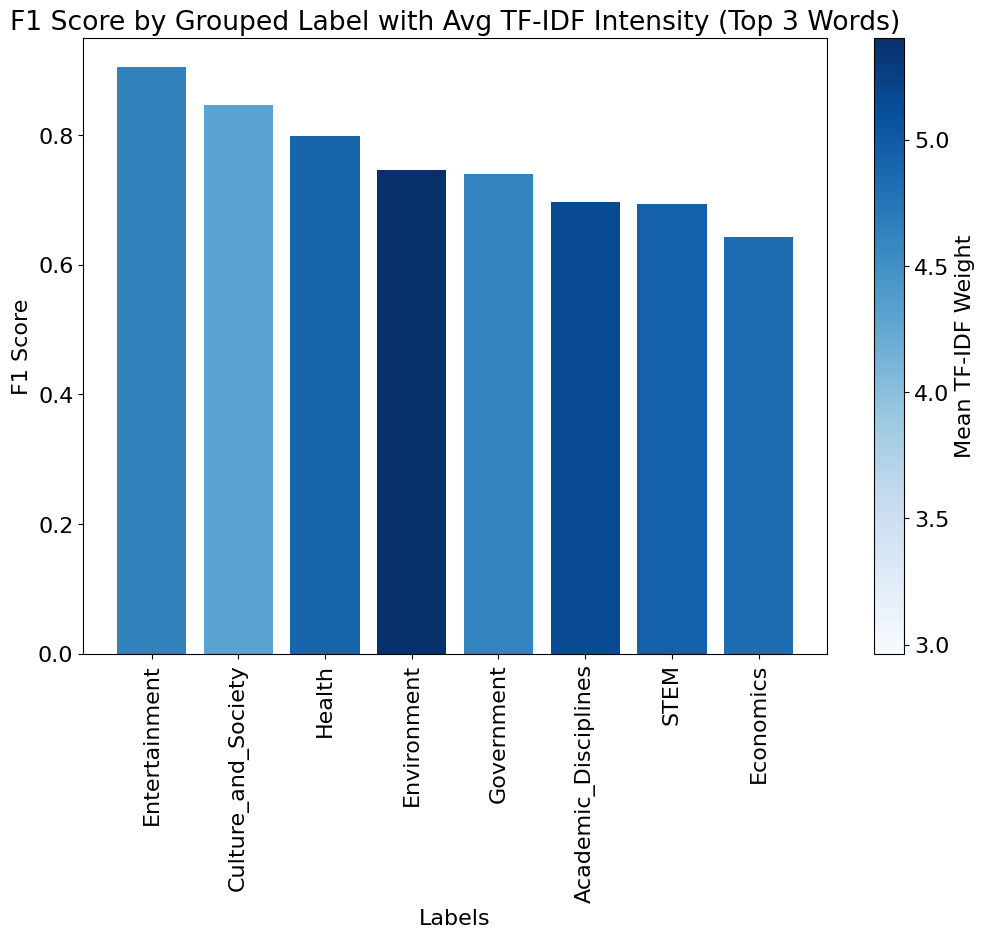

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Supponiamo che y_test_grouped e y_pred_logreg_test_grouped siano già definiti
report = classification_report(y_test_grouped, y_pred_logreg_test_grouped, target_names=y_test_grouped.columns, output_dict=True)

# Estrai l'F1 score per ogni etichetta raggruppata
labels = y_test_grouped.columns
f1_scores = [report[label]['f1-score'] for label in labels]

# Calcola la media del TF-IDF delle 3 parole più influenti per ogni etichetta
mean_tfidf = []
for label in labels:
    tfidf_values = [tfidf for word, coef, tfidf in top_words_per_label[label]]
    mean_tfidf.append(np.mean(tfidf_values))

# Ordina le etichette, gli F1 score, e i TF-IDF medi in base all'F1 score dal più alto al più basso
sorted_indices = np.argsort(f1_scores)[::-1]  # Ordina dal più alto al più basso
labels = np.array(labels)[sorted_indices]
f1_scores = np.array(f1_scores)[sorted_indices]
mean_tfidf = np.array(mean_tfidf)[sorted_indices]

# Normalizza i valori TF-IDF per mappare l'intensità del colore
norm_tfidf = mean_tfidf / np.max(mean_tfidf)

# Imposta la dimensione del font
font_size = 16
plt.rcParams.update({'font.size': font_size})

# Crea il barplot con l'intensità del colore basata sulla media TF-IDF utilizzando una scala di blu
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, f1_scores, color=plt.cm.Blues(norm_tfidf))

# Aggiungi etichette e titolo in inglese
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Score by Grouped Label with Avg TF-IDF Intensity (Top 3 Words)')
plt.xticks(rotation=90)
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(mean_tfidf), vmax=np.max(mean_tfidf))), label='Mean TF-IDF Weight')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-30-6bcf39d9fdde>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(supports), vmax=np.max(supports))), label='Support')


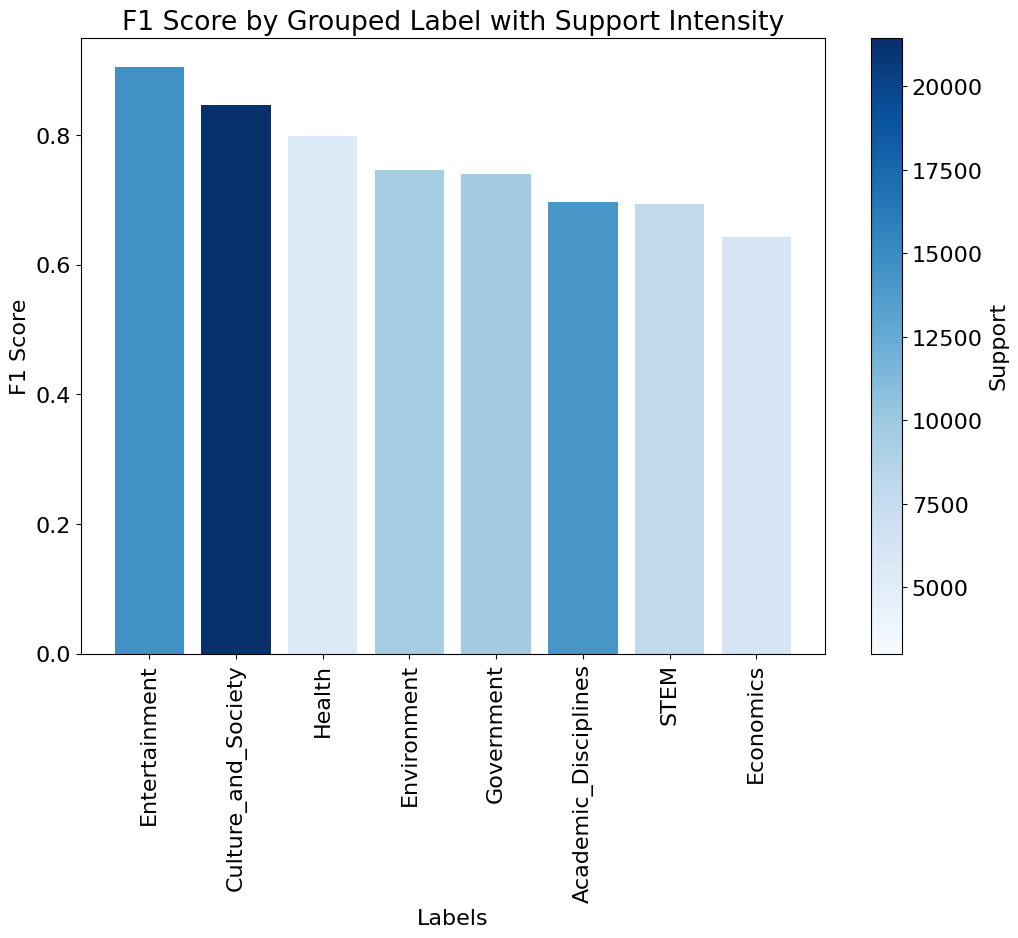

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Supponiamo che y_test_grouped e y_pred_logreg_test_grouped siano già definiti
report = classification_report(y_test_grouped, y_pred_logreg_test_grouped, target_names=y_test_grouped.columns, output_dict=True)

# Estrai l'F1 score per ogni etichetta raggruppata
labels = y_test_grouped.columns
f1_scores = [report[label]['f1-score'] for label in labels]

# Estrai la numerosità (support) per ogni etichetta raggruppata
supports = [report[label]['support'] for label in labels]

# Ordina le etichette, gli F1 score, e i support in base all'F1 score dal più alto al più basso
sorted_indices = np.argsort(f1_scores)[::-1]  # Ordina dal più alto al più basso
labels = np.array(labels)[sorted_indices]
f1_scores = np.array(f1_scores)[sorted_indices]
supports = np.array(supports)[sorted_indices]

# Normalizza i valori di support per mappare l'intensità del colore
norm_supports = supports / np.max(supports)

# Crea il barplot con l'intensità del colore basata sul support utilizzando una scala di blu
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, f1_scores, color=plt.cm.Blues(norm_supports))

# Aggiungi etichette e titolo in inglese
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Score by Grouped Label with Support Intensity')
plt.xticks(rotation=90)
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(supports), vmax=np.max(supports))), label='Support')
plt.show()
